# Forecasting Time Series - In Depth

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/autogluon/autogluon/blob/master/docs/tutorials/timeseries/forecasting-indepth.ipynb)
[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/autogluon/autogluon/blob/master/docs/tutorials/timeseries/forecasting-indepth.ipynb)


This tutorial provides an in-depth overview of the time series forecasting capabilities in AutoGluon.
Specifically, we will cover:

- What is probabilistic time series forecasting?
- Forecasting time series with additional information
- What data format is expected by `TimeSeriesPredictor`?
- How to evaluate forecast accuracy?
- Which forecasting models are available in AutoGluon?
- What functionality does `TimeSeriesPredictor` offer?
    - Basic configuration with `presets` and `time_limit`
    - Manually selecting what models to train
    - Hyperparameter tuning

This tutorial assumes that you are familiar with the contents of [Forecasting Time Series - Quick Start](forecasting-quick-start.ipynb).

## What is probabilistic time series forecasting?
A time series is a sequence of measurements made at regular intervals.
The main objective of time series forecasting is to predict the future values of a time series given the past observations.
A typical example of this task is demand forecasting.
For example, we can represent the number of daily purchases of a certain product as a time series.
The goal in this case could be predicting the demand for each of the next 14 days (i.e., the forecast horizon) given the historical purchase data.
In AutoGluon, the `prediction_length` argument of the `TimeSeriesPredictor` determines the length of the forecast horizon.

![Main goal of forecasting is to predict the future values of a time series given the past observations.](https://autogluon-timeseries-datasets.s3.us-west-2.amazonaws.com/public/figures/forecasting-indepth1.png)

The objective of forecasting could be to predict future values of a given time series, as well as establishing prediction intervals within which the future values will likely lie.
In AutoGluon, the `TimeSeriesPredictor` generates two types of forecasts:

- **mean forecast** represents the expected value of the time series at each time step in the forecast horizon.
- **quantile forecast** represents the quantiles of the forecast distribution.
For example, if the `0.1` quantile (also known as P10, or the 10th percentile) is equal to `x`, it means that the time series value is predicted to be below `x` 10% of the time. As another example, the `0.5` quantile (P50) corresponds to the median forecast.
Quantiles can be used to reason about the range of possible outcomes.
For instance, by the definition of the quantiles, the time series is predicted to be between the P10 and P90 values with 80% probability.


![Mean and quantile (P10 and P90) forecasts.](https://autogluon-timeseries-datasets.s3.us-west-2.amazonaws.com/public/figures/forecasting-indepth2.png)

By default, the `TimeSeriesPredictor` outputs the quantiles `[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]`. Custom quantiles can be provided with the `quantile_levels` argument

```python
predictor = TimeSeriesPredictor(quantile_levels=[0.05, 0.5, 0.95])
```

## Forecasting time series with additional information
In real-world forecasting problems we often have access to additional information, beyond just the raw time series values.
AutoGluon supports two types of such additional information: static features and time-varying covariates.

### Static features
Static features are the time-independent attributes (metadata) of a time series.
These may include information such as:

- location, where the time series was recorded (country, state, city)
- fixed properties of a product (brand name, color, size, weight)
- store ID or product ID

Providing this information may, for instance, help forecasting models generate similar demand forecasts for stores located in the same city.

In AutoGluon, static features are stored as an attribute of a `TimeSeriesDataFrame` object.
As an example, let's have a look at the M4 Daily dataset.

In [ ]:
!pip install autogluon.timeseries


In [2]:
import warnings
warnings.filterwarnings(action="ignore")

In [3]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

We download a subset of 100 time series as a TimeSeriesDataFrame

In [4]:
train_data = TimeSeriesDataFrame.from_path(
    "https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_daily_subset/train.csv",
)
train_data.head()

target
item_id timestamp                  
D1737   1995-05-23 12:00:00  1900.0
        1995-05-24 12:00:00  1877.0
        1995-05-25 12:00:00  1873.0
        1995-05-26 12:00:00  1859.0
        1995-05-27 12:00:00  1876.0

AutoGluon expects static features as a pandas.DataFrame object, where the index column includes all the `item_id`s present in the respective TimeSeriesDataFrame.

In [5]:
static_features = pd.read_csv(
    "https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_daily_subset/metadata.csv",
    index_col="item_id",
)
static_features.head()

,domain
item_id,
D1737,Industry
D1843,Industry
D2246,Finance
D909,Micro
D1345,Micro


In the M4 Daily dataset, there is a single categorical static feature that denotes the domain of origin for each time series.

We attach the static features to a TimeSeriesDataFrame as follows

```python
train_data.static_features = static_features
```

If `static_features` doesn't contain some `item_id`s that are present in `train_data`, an exception will be raised.

Now, when we fit the predictor, all models that support static features will automatically use the static features included in `train_data`.

```python
predictor = TimeSeriesPredictor(prediction_length=14).fit(train_data)
```

```
...
Following types of static features have been inferred:
	categorical: ['domain']
	continuous (float): []
...
```

This message confirms that column `'domain'` was interpreted as a categorical feature.
In general, AutoGluon-TimeSeries supports two types of static features:

- `categorical`: columns of dtype `object`, `string` and `category` are interpreted as discrete categories
- `continuous`: columns of dtype `int` and `float` are interpreted as continuous (real-valued) numbers
- columns with other dtypes are ignored

To override this logic, we need to manually change the columns dtype.
For example, suppose the static features data frame contained an integer-valued column `"store_id"`.

```python
train_data.static_features["store_id"] = list(range(len(train_data.item_ids)))
```

By default, this column will be interpreted as a continuous number.
We can force AutoGluon to interpret it a a categorical feature by changing the dtype to `category`.

```python
train_data.static_features["store_id"] = train_data.static_features["store_id"].astype("category")
```

**Note:** If training data contained static features, the predictor will expect that data passed to `predictor.predict()`, `predictor.leaderboard()`, and `predictor.evaluate()` also includes static features with the same column names and data types.


### Time-varying covariates
Covariates are the time-varying features that may influence the target time series.
They are sometimes also referred to as dynamic features, exogenous regressors, or related time series.
AutoGluon supports two types of covariates:

- *known* covariates that are known for the entire forecast horizon, such as
    - holidays
    - day of the week, month, year
    - promotions

- *past* covariates that are only known up to the start of the forecast horizon, such as
    - sales of other products
    - temperature, precipitation
    - transformed target time series


![Target time series with one past covariate and one known covariate.](https://autogluon-timeseries-datasets.s3.us-west-2.amazonaws.com/public/figures/forecasting-indepth5.png)

In AutoGluon, both `known_covariates` and `past_covariates` are stored as additional columns in the `TimeSeriesDataFrame`.

We will again use the M4 Daily dataset as an example and generate both types of covariates:

- a `past_covariate` equal to the logarithm of the target time series:
- a `known_covariate` that equals to 1 if a given day is a weekend, and 0 otherwise.

In [6]:
import numpy as np
train_data["log_target"] = np.log(train_data["target"])

WEEKEND_INDICES = [5, 6]
timestamps = train_data.index.get_level_values("timestamp")
train_data["weekend"] = timestamps.weekday.isin(WEEKEND_INDICES).astype(float)

train_data.head()

target  log_target  weekend
item_id timestamp                                       
D1737   1995-05-23 12:00:00  1900.0    7.549609      0.0
        1995-05-24 12:00:00  1877.0    7.537430      0.0
        1995-05-25 12:00:00  1873.0    7.535297      0.0
        1995-05-26 12:00:00  1859.0    7.527794      0.0
        1995-05-27 12:00:00  1876.0    7.536897      1.0

When creating the TimeSeriesPredictor, we specify that the column `"target"` is our prediction target, and the
column `"weekend"` contains a covariate that will be known at prediction time.

```python
predictor = TimeSeriesPredictor(
    prediction_length=14,
    target="target",
    known_covariates_names=["weekend"],
).fit(train_data)
```

Predictor will automatically interpret the remaining columns (except target and known covariates) as past covariates.
This information is logged during fitting:

```
...
Provided dataset contains following columns:
	target:           'target'
	known covariates: ['weekend']
	past covariates:  ['log_target']
...
```

Finally, to make predictions, we generate the known covariates for the forecast horizon

In [7]:
from autogluon.timeseries.utils.forecast import get_forecast_horizon_index_ts_dataframe

future_index = get_forecast_horizon_index_ts_dataframe(train_data, prediction_length=14)
future_timestamps = future_index.get_level_values("timestamp")
known_covariates = pd.DataFrame(index=future_index)
known_covariates["weekend"] = future_timestamps.weekday.isin(WEEKEND_INDICES).astype(float)

known_covariates.head()

weekend
item_id timestamp                   
D1737   1997-05-28 12:00:00      0.0
        1997-05-29 12:00:00      0.0
        1997-05-30 12:00:00      0.0
        1997-05-31 12:00:00      1.0
        1997-06-01 12:00:00      1.0

Note that `known_covariates` must satisfy the following conditions:

- The columns must include all columns listed in ``predictor.known_covariates_names``
- The ``item_id`` index must include all item ids present in ``train_data``
- The ``timestamp`` index must include the values for ``prediction_length`` many time steps into the future from the end of each time series in ``train_data``

If `known_covariates` contain more information than necessary (e.g., contain additional columns, item_ids, or timestamps),
AutoGluon will automatically select the necessary rows and columns.

Finally, we pass the `known_covariates` to the `predict` function to generate predictions

```python
predictor.predict(train_data, known_covariates=known_covariates)
```

The list of models that support static features and covariates is available in [Forecasting Model Zoo](forecasting-model-zoo.md).

## What data format is expected by `TimeSeriesPredictor`?

There are several assumptions that AutoGluon places on the data to ensure that all models can work as expected:
- All time series must have length ≥ 3.
- Training data must contain at least some time series with length ≥ `2 * prediction_length + 1`. This is necessary to ensure that there is some data available to use as an internal validation set.
- All time series must be regularly sampled (e.g., measurements made every day).
- There are no missing values in the data.

Note that all time series in the dataset can have different lengths.


### Handling irregular data and missing values 
In some applications, like finance, data often comes with irregular measurements (e.g., no stock price is available for weekends or holidays) or missing values.
AutoGluon provides two options for working with such data.

**Option 1: Extend the index and fill the missing values (Recommended)**

Here is an example of a dataset with an irregular time index:

In [8]:
df_irregular = TimeSeriesDataFrame(
    pd.DataFrame(
        {
            "item_id": [0, 0, 0, 1, 1],
            "timestamp": ["2022-01-01", "2022-01-02", "2022-01-04", "2022-01-01", "2022-01-04"],
            "target": [1, 2, 3, 4, 5],
        }
    )
)
df_irregular

target
item_id timestamp         
0       2022-01-01       1
        2022-01-02       2
        2022-01-04       3
1       2022-01-01       4
        2022-01-04       5

We can fill the gaps in the time index using the method [TimeSeriesDataFrame.to_regular_index()](../../api/autogluon.timeseries.TimeSeriesDataFrame.to_regular_index.rst).
Here we specify `freq="D"` to indicate that the filled index must have a daily frequency
(see [other possible choices in pandas documentation](https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-offset-aliases)).

In [9]:
df_regular = df_irregular.to_regular_index(freq="D")
df_regular

target
item_id timestamp         
0       2022-01-01     1.0
        2022-01-02     2.0
        2022-01-03     NaN
        2022-01-04     3.0
1       2022-01-01     4.0
        2022-01-02     NaN
        2022-01-03     NaN
        2022-01-04     5.0

We can verify that the index is now regular and has a daily frequency

In [10]:
print(f"Data has frequency '{df_regular.freq}'")

Data has frequency 'D'


However, now the data contains missing values represented by `NaN`.
To fill the NaNs, we use the method [TimeSeriesDataFrame.fill_missing_values()](../../api/autogluon.timeseries.TimeSeriesDataFrame.fill_missing_values.rst) that implements various imputation strategies.

In [11]:
df_filled = df_regular.fill_missing_values()
df_filled

target
item_id timestamp         
0       2022-01-01     1.0
        2022-01-02     2.0
        2022-01-03     2.0
        2022-01-04     3.0
1       2022-01-01     4.0
        2022-01-02     4.0
        2022-01-03     4.0
        2022-01-04     5.0

Now the data has a regular index and contains no missing values, so it can be used to train a `TimeSeriesPredictor`.

**Option 2: Use dummy time index (Not Recommended)**

Another option is to replace the timestamps with a dummy index using the `get_reindexed_view` method.

In [12]:
df_with_dummy_index = df_irregular.get_reindexed_view()
df_with_dummy_index

target
item_id timestamp                  
0       1900-01-01 00:00:00       1
        1900-01-01 00:00:01       2
        1900-01-01 00:00:02       3
1       1900-01-01 00:00:00       4
        1900-01-01 00:00:01       5

When we pass `df_with_dummy_index` to the `TimeSeriesPredictor`, the predictions will also be based on the dummy index and seasonality will be disabled for most models.

## How to evaluate forecast accuracy?

To measure how accurately `TimeSeriesPredictor` can forecast unseen time series, we need to reserve some test data that won't be used for training.
This can be easily done using the `train_test_split` method of a `TimeSeriesDataFrame`:

In [13]:
prediction_length = 48
data = TimeSeriesDataFrame.from_path("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/train.csv")
train_data, test_data = data.train_test_split(prediction_length)

We obtained two `TimeSeriesDataFrame`s from our original data:
- `test_data` contains exactly the same data as the original `data`
- In `train_data`, the last `prediction_length` time steps are removed from the end of each time series

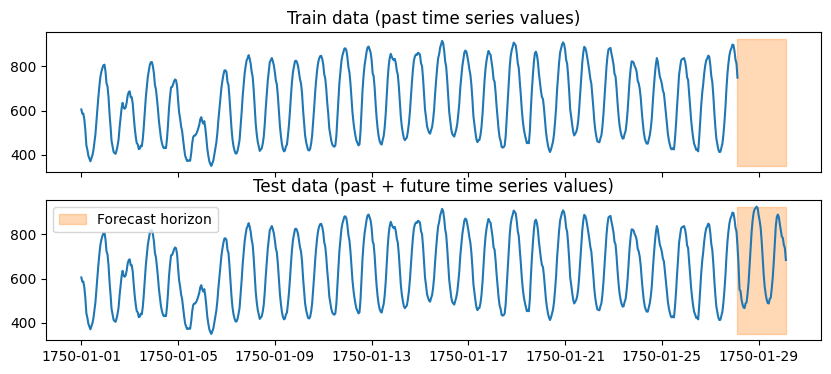

In [14]:
import matplotlib.pyplot as plt
import numpy as np

item_id = "H1"
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=[10, 4], sharex=True)
train_ts = train_data.loc[item_id]
test_ts = test_data.loc[item_id]
ax1.set_title("Train data (past time series values)")
ax1.plot(train_ts)
ax2.set_title("Test data (past + future time series values)")
ax2.plot(test_ts)
for ax in (ax1, ax2):
    ax.fill_between(np.array([train_ts.index[-1], test_ts.index[-1]]), test_ts.min(), test_ts.max(), color="C1", alpha=0.3, label="Forecast horizon")
plt.legend()
plt.show()

We can now use `train_data` to train the predictor, and `test_data` to obtain an estimate of its performance on unseen data.
```python
predictor = TimeSeriesPredictor(prediction_length=prediction_length, eval_metric="MASE").fit(train_data)
predictor.evaluate(test_data)
```

AutoGluon evaluates the performance of forecasting models by measuring how well their forecasts align with the actually observed time series.
For each time series in `test_data`, the predictor does the following:

1. Hold out the last `prediction_length` values of the time series.
2. Generate a forecast for the held out part of the time series, i.e., the forecast horizon.
3. Quantify how well the forecast matches the actually observed (held out) values of the time series using the `eval_metric`.

Finally, the scores are averaged over all time series in the dataset.

The crucial detail here is that `evaluate` always computes the score on the last `prediction_length` time steps of each time series.
The beginning of each time series (except the last `prediction_length` time steps) is only used to initialize the models before forecasting.

### Backtesting using multiple windows

We can more accurately estimate the performance using **backtest** (i.e., evaluate performance on multiple forecast horizons generated from the same time series).
This can be done using a `MultiWindowSplitter`.

```python
from autogluon.timeseries.splitter import MultiWindowSplitter

splitter = MultiWindowSplitter(num_windows=5)
train_data, test_data_multi_window = splitter.split(test_data, prediction_length)

predictor.evaluate(test_data_multi_window)
```

The new test set `test_data_multi_window` will now contain up to `num_windows` time series for each original time series in `test_data`.
The score will be computed on the last `prediction_length` time steps of each time series (marked in orange).

![MultiWindowSplitter splits each original time series into multiple evaluation instances. Forecast is evaluated on the last `prediction_length` timesteps (orange).](https://autogluon-timeseries-datasets.s3.us-west-2.amazonaws.com/public/figures/forecasting-indepth3.png)

Multi-window backtesting typically results in more accurate estimation of the forecast quality on unseen data.
However, this strategy decreases the amount of training data available for fitting models, so we recommend using single-window backtesting if the training time series are short.

### How to choose and interpret the evaluation metric?
Different evaluation metrics capture different properties of the forecast, and therefore depend on the application that the user has in mind.
Here is a very rough guide outlining some scenarios when you can prefer different metrics:

- `mean_wQuantileLoss` - if you care about the quantile forecasts (all other metrics ignore the quantile forecasts)
- `MASE` or `sMAPE` - if you care about an accurate forecast for each time series, regardless of its scale
- `MAE` - if you care about accurately predicting time series with larger scale (e.g., accurately predicting demand for popular items)
- `RMSE` - similar to `MAE`, but penalizes large mispredictions more strongly

For more details about the available metrics, see the documentation for [autogluon.timeseries.evaluator.TimeSeriesEvaluator](https://github.com/autogluon/autogluon/blob/master/timeseries/src/autogluon/timeseries/evaluator.py#L53) or this [article](https://docs.aws.amazon.com/forecast/latest/dg/metrics.html).

Note that AutoGluon always reports all metrics in a **higher-is-better** format.
For this purpose, some metrics are multiplied by -1.
For example, if we set `eval_metric="MASE"`, the predictor will actually report `-MASE` (i.e., MASE score multiplied by -1). This means the `test_score` will be between 0 (best possible forecast) and $-\infty$ (worst possible forecast).


### How does AutoGluon perform validation?
When we fit the predictor with `predictor.fit(train_data=train_data)`, under the hood AutoGluon further splits the original dataset `train_data` into train and validation parts.

Performance of different models on the validation set is evaluated using the `evaluate` method, just like described above.
The model that achieves the best validation score will be used for prediction in the end.

By default, the internal validation set contains a single window containing the last `prediction_length` time steps of each time series. We can increase the number of validation windows using the `num_val_windows` argument.

```python
predictor = TimeSeriesPredictor(...)
predictor.fit(train_data, num_val_windows=3)
```
This will reduce the likelihood of overfitting but will increase the training time approximately by a factor of `num_val_windows`.
Note that multiple validation windows can only be used if the time series in `train_data` have length of at least `(num_val_windows + 1) * prediction_length`.

Alternatively, a user can provide their own validation set to the `fit` method. In this case it's important to remember that the validation score is computed on the last `prediction_length` time steps of each time series.

```python
predictor.fit(train_data=train_data, tuning_data=my_validation_dataset)
```

## Which forecasting models are available in AutoGluon?
Forecasting models in AutoGluon can be divided into three broad categories: local, global, and ensemble models.

**Local models** are simple statistical models that are specifically designed to capture patterns such as trend or seasonality.
Despite their simplicity, these models often produce reasonable forecasts and serve as a strong baseline.
Some examples of available local models:

- `ETS`
- `ARIMA`
- `Theta`
- `SeasonalNaive`

If the dataset consists of multiple time series, we fit a separate local model to each time series — hence the name "local".
This means, if we want to make a forecast for a new time series that wasn't part of the training set, all local models will be fit from scratch for the new time series.

**Global models** are machine learning algorithms that learn a single model from the entire training set consisting of multiple time series.
Most global models in AutoGluon are provided by the [GluonTS](https://ts.gluon.ai/stable/) library.
These are neural-network algorithms (implemented in PyTorch or MXNet), such as:

- `DeepAR`
- `PatchTST`
- `TemporalFusionTransformer`

AutoGluon also offers two tabular global models `RecursiveTabular` and `DirectTabular`.
Under the hood, these models convert the forecasting task into a regression problem and use a [TabularPredictor](../../api/autogluon.tabular.TabularPredictor.rst) to fit regression algorithms like LightGBM.

Finally, an **ensemble** model works by combining predictions of all other models.
By default, `TimeSeriesPredictor` always fits a `WeightedEnsemble` on top of other models.
This can be disabled by setting `enable_ensemble=False` when calling the `fit` method.

For a list of tunable hyperparameters for each model, their default values, and other details see [Forecasting Model Zoo](forecasting-model-zoo.md).

## Which forecasting models are available in AutoGluon?
Forecasting models in AutoGluon can be divided into three broad categories: local, global, and ensemble models.

**Local models** are simple statistical models that are specifically designed to capture patterns such as trend or seasonality.
Despite their simplicity, these models often produce reasonable forecasts and serve as a strong baseline.
Some examples of available local models:

- `ETS`
- `ARIMA`
- `Theta`
- `SeasonalNaive`

If the dataset consists of multiple time series, we fit a separate local model to each time series — hence the name "local".
This means, if we want to make a forecast for a new time series that wasn't part of the training set, all local models will be fit from scratch for the new time series.

**Global models** are machine learning algorithms that learn a single model from the entire training set consisting of multiple time series.
Most global models in AutoGluon are provided by the [GluonTS](https://ts.gluon.ai/stable/) library.
These are neural-network algorithms (usually implemented in PyTorch), such as:

- `DeepAR`
- `PatchTST`
- `TemporalFusionTransformer`

AutoGluon also offers tree-based global models `RecursiveTabular` and `DirectTabular`.
Under the hood, these models convert the forecasting task into a regression problem and use a [TabularPredictor](../../api/autogluon.tabular.TabularPredictor.rst) to fit regression algorithms like LightGBM.

Finally, an **ensemble** model works by combining predictions of all other models.
By default, `TimeSeriesPredictor` always fits a `WeightedEnsemble` on top of other models.
This can be disabled by setting `enable_ensemble=False` when calling the `fit` method.

For a list of tunable hyperparameters for each model, their default values, and other details see [Forecasting Model Zoo](forecasting-model-zoo.md).



## What functionality does `TimeSeriesPredictor` offer?
AutoGluon offers multiple ways to configure the behavior of a `TimeSeriesPredictor` that are suitable for both beginners and expert users.

### Basic configuration with `presets` and `time_limit`
We can fit `TimeSeriesPredictor` with different pre-defined configurations using the `presets` argument of the `fit` method.

```python
predictor = TimeSeriesPredictor(...)
predictor.fit(train_data, presets="medium_quality")
```

Higher quality presets usually result in better forecasts but take longer to train.
The following presets are available:

- ``"fast_training"``: fit simple statistical models (``ETS``, ``Theta``, ``Naive``, ``SeasonalNaive``) + fast tree-based model ``RecursiveTabular``. These models are fast to train but may not be very accurate.
- ``"medium_quality"``: all models mentioned above + deep learning model ``DeepAR``. Default setting that produces good forecasts with reasonable training time.
- ``"high_quality"``: all models mentioned above + automatically tuned statistical models (``AutoETS``, ``AutoARIMA``) + tree-based model ``DirectTabular`` + deep learning models ``TemporalFusionTransformer`` and ``PatchTST`` . Much more accurate than ``medium_quality``, but takes longer to train.
- ``"best_quality"``: all models mentioned above + more tabular models + training multiple copies of ``DeepAR``. Usually better than ``high_quality``, but takes even longer to train.

Another way to control the training time is using the `time_limit` argument.

```python
predictor.fit(
    train_data,
    time_limit=60 * 60,  # total training time in seconds
)
```

If no `time_limit` is provided, the predictor will train until all models have been fit.


### Manually configuring models
Advanced users can override the presets and manually specify what models should be trained by the predictor using the `hyperparameters` argument.

```python
predictor = TimeSeriesPredictor(...)

predictor.fit(
    ...
    hyperparameters={
        "DeepAR": {},
        "ETS": [
            {"seasonal": "add"},
            {"seasonal": None},
        ],
    }
)
```

The above example will train three models:

* ``DeepAR`` with default hyperparameters
* ``ETS`` with additive seasonality (all other parameters set to their defaults)
* ``ETS`` with seasonality disabled (all other parameters set to their defaults)

You can also exclude certain models from the presets using the `excluded_model_type` argument.
```python
predictor.fit(
    ...
    presets="high_quality",
    excluded_model_types=["AutoETS", "AutoARIMA"],
)
```

For the full list of available models and the respective hyperparameters, see [Forecasting Model Zoo](forecasting-model-zoo.md).

### Hyperparameter tuning

Advanced users can define search spaces for model hyperparameters and let AutoGluon automatically determine the best configuration for the model.

```python
from autogluon.common import space

predictor = TimeSeriesPredictor()

predictor.fit(
    train_data,
    hyperparameters={
        "DeepAR": {
            "hidden_size": space.Int(20, 100),
            "dropout_rate": space.Categorical(0.1, 0.3),
        },
    },
    hyperparameter_tune_kwargs="auto",
    enable_ensemble=False,
)
```

This code will train multiple versions of the `DeepAR` model with 10 different hyperparameter configurations.
AutGluon will automatically select the best model configuration that achieves the highest validation score and use it for prediction.

AutoGluon uses different hyperparameter optimization (HPO) backends for different models:

- Ray Tune for GluonTS models implemented in `MXNet` (e.g., `DeepARMXNet`, `TemporalFusionTransformerMXNet`)
- Custom backend implementing random search for all other models

We can change the number of random search runs by passing a dictionary as `hyperparameter_tune_kwargs`

```python
predictor.fit(
    ...
    hyperparameter_tune_kwargs={
        "scheduler": "local",
        "searcher": "random",
        "num_trials": 20,
    },
    ...
)
```

The `hyperparameter_tune_kwargs` dict must include the following keys:

- ``"num_trials"``: int, number of configurations to train for each tuned model
- ``"searcher"``: one of ``"random"`` (random search), ``"bayes"`` (bayesian optimization for GluonTS MXNet models, random search for other models) and ``"auto"`` (same as ``"bayes"``).
- ``"scheduler"``: the only supported option is ``"local"`` (all models trained on the same machine)

**Note:** HPO significantly increases the training time for most models, but often provides only modest performance gains.